# 04.2 Fixed Sum

In this case, I want to fix the test strings to have no more than a certain sum. The test strings can be arbitrarily long, but they can only sum up to a certain amount (that the train strings also sum up to). 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd drive/My\ Drive/CS281\ Final\ Project

## Package Loading

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from sklearn.model_selection import train_test_split
device = 'cuda'
from random import shuffle
import sys
import pickle

## Model Definition

In [0]:
class Counter():
    def __init__(self, hidden):
        '''hidden is the number of hidden variables to use per cell'''

        #this LSTM goes from input [batch x length x 1] to output [batch x length x hidden]
        self.lstm = nn.LSTM(1, hidden, batch_first=True).double().cuda() 

        #this matrix transforms from [1 x hidden] to [1 x 1]
        self.combine = torch.randn([hidden,1], dtype=float, device=device, requires_grad=True) 

        params = list(self.lstm.parameters())
        params.append(self.combine)
        self.optimizer = optim.Adam(params)

    @staticmethod
    def convert_sequence(seq):
        '''converts a set of sequences with the same length from array or numpy into a correctly formatted tensor.
        Shape: [batch x length x 1]'''
        seq = torch.tensor(seq, device=device).double()
        seq = seq.reshape([len(seq), -1, 1])
        return seq

    def predict(self, sequence):
        '''takes a tensor, predicts the sum of the tensor, and compares to the actual sum of the tensor. 
        Returns the loss and the predicted sum'''
        pred, _ = self.lstm(sequence)
        pred = pred[:,-1,:] @ self.combine 
        #the second index is the rolling output. The final output is the last element in that index

        loss = (pred - sequence.sum(1)).pow(2)
        return loss, pred

    def predict_multilength(self, sequences):
        '''Takes a list of batches of tensors of different length. Predicts on each batch. Sums up the loss. Reduces to a single mean'''
        loss = torch.tensor(0, device=device).double()
        count= torch.tensor(0, device=device).double()
        for s in sequences:
            pred = self.predict(s)[0]
            count += pred.shape[0]
            loss += pred.sum()
        return loss / count

## Model Testing

In [0]:
def round_partition(p):
    '''Rounds a partition so that the sum of the partition equals the original sum'''
    rounded = np.round(p).astype(int)
    ind = len(rounded)-1
    while rounded.sum() < p.sum():
        rounded[ind] += 1
        ind -= 1
    return rounded

def generate_data(length, total, cap):
    counts = np.random.dirichlet((np.arange(length)+1)**2) * total * 0.9
    counts = round_partition(counts)

    train_set = []
    val_set = []
    test_set = []
    for i in range(1,length+1):
        if counts[i-1] == 0:
            continue
        seqs = np.random.randint(0,2, size=[counts[i-1],i])
        seqs = seqs[seqs.sum(1) <= cap]
        seqs = np.unique(seqs, axis=0)[:,:,None]
        try:
            train, val = train_test_split(seqs, test_size=2/9, shuffle=True)
            train = Counter.convert_sequence(train)
            val = Counter.convert_sequence(val)
            train_set.append(train)
            val_set.append(val)
        except ValueError:
            train = Counter.convert_sequence(seqs)
            train_set.append(train)
            continue
    counts = np.random.dirichlet((np.arange(length, 2*length)+1)**2) * total * 0.1
    counts = round_partition(counts)

    for i in range(length):
        if counts[i] == 0:
            continue
        seqs = []
        # seqs = np.random.randint(0,2, size=[counts[i],i+length+1])
        # seqs = seqs[seqs.sum(1) <= cap]
        for _ in range(counts[i]):
            s = np.random.randint(0,cap+1)
            sample = np.zeros([i+length+1], dtype=int)
            sample[np.random.choice(i+length+1,size=(s,), replace=False)] += 1
            seqs.append(sample)
        seqs = np.unique(seqs, axis=0)[:,:,None]
        seqs = Counter.convert_sequence(seqs)
        test_set.append(seqs)

    return train_set, val_set, test_set

In [0]:
#generate all the strings and partition into train and test
length = 64
cap = length/2
hidden = 10
depth = 100000

output_folder = "Part-4.2-Outputs"

In [0]:
# train, val, test = generate_data(length,depth, cap)

# with open("%s/Data.pickle"%output_folder, "wb") as f:
#     pickle.dump([train, val, test], f)

In [0]:
with open("%s/Data.pickle"%output_folder, "rb") as f:
    train, val, test = pickle.load(f)

In [0]:
trainsize = sum([x.shape[0] for x in train])
valsize = sum([x.shape[0] for x in val])
testsize = sum([x.shape[0] for x in test])
print(trainsize, valsize, testsize)

total = trainsize+valsize+testsize
print("Total:",total) 
print("Fraction %.3f %.3f %.3f"%(trainsize/total, valsize/total, testsize/total))

print("Train    length range: %d-%d"%(min([x.shape[1] for x in train]), max([x.shape[1] for x in train])))
print("Validate length range: %d-%d"%(min([x.shape[1] for x in val]), max([x.shape[1] for x in val])))
print("Test     length range: %d-%d"%(min([x.shape[1] for x in test]), max([x.shape[1] for x in test])))
print("Train    sum    range: %d-%d"%(min([min(x.sum(1)) for x in train]), max([max(x.sum(1)) for x in train])))
print("Validate sum    range: %d-%d"%(min([min(x.sum(1)) for x in val]), max([max(x.sum(1)) for x in val])))
print("Test     sum    range: %d-%d"%(min([min(x.sum(1)) for x in test]), max([max(x.sum(1)) for x in test])))


62309 17835 9763
Total: 89907
Fraction 0.693 0.198 0.109
Train    length range: 1-64
Validate length range: 2-64
Test     length range: 65-128
Train    sum    range: 0-32
Validate sum    range: 1-32
Test     sum    range: 0-32


## Model Training

In [0]:
model = Counter(hidden)

history = []
best = float('inf')
patience = 10
tol = 0.001
count = 0

for epoch in range(1000000): 
    shuffle(train)
    shuffle(val)
    if epoch % 100 == 0:
        train_loss = model.predict_multilength(train).item()
        with torch.no_grad():
            val_loss = model.predict_multilength(val).item()
        history.append([train_loss, val_loss])
        print("Epoch: %5d. Train Loss: %7.3f. Validation Loss: %7.3f"%(epoch, train_loss, val_loss))

        if val_loss + tol < best:
            best = val_loss
            count = 0
            torch.save(model, "%s/Model-%d"%(output_folder, hidden))

        else:
            count += 1
        if count >= patience:
            break

    #take the average loss over all the train data
    loss = model.predict_multilength(train)   
    #and update
    model.optimizer.zero_grad()
    loss.backward(retain_graph=True)
    model.optimizer.step()

#display testing results
loss = model.predict_multilength(test)
print("Average Test Loss:", loss.item())

history = np.array(history)
np.save("%s/Train-%d"%(output_folder, hidden), history)


## Results

In [0]:
model = torch.load(f"{output_folder}/Model-10")

In [0]:
print("Train:   ", model.predict_multilength(train).item())
print("Validate:", model.predict_multilength(val).item())
print("Test:    ", model.predict_multilength(test).item())


Train:    0.008046162896784635
Validate: 0.008739182390171948
Test:     0.7491200997894051


In [0]:
res = []
for s in range(3):
    for chunk in [train, val, test][s]:
        length = chunk.shape[1]
        for sample in chunk:
            sample = sample.unsqueeze(0)
            res.append([["Train", "Validate", "Test"][s],length, sample.sum(1).item(), model.predict(sample)[1].item()])
res = pd.DataFrame(res, columns=["Partition", "Length", "True Count", "Predicted Count"])
res['Error'] = np.abs(res['Predicted Count'] - res['True Count'])

In [0]:
res.to_csv("%s/Testing-4.2"%output_folder)

In [0]:
res

,Partition,Length,True Count,Predicted Count,Error
0,Train,1,1.0,2.974891,1.974891
1,Train,2,1.0,3.320487,2.320487
2,Train,2,1.0,3.235306,2.235306
3,Train,3,2.0,4.683051,2.683051
4,Train,3,1.0,2.913814,1.913814
...,...,...,...,...,...
89902,Test,128,13.0,13.848186,0.848186
89903,Test,128,27.0,27.612363,0.612363
89904,Test,128,27.0,27.200714,0.200714
89905,Test,128,28.0,28.087744,0.087744


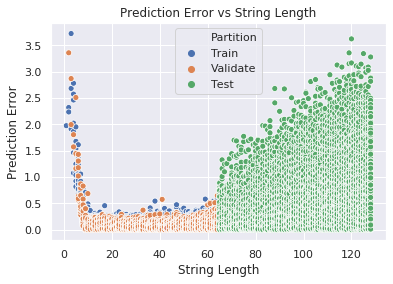

In [0]:
sns.set()
sns.scatterplot(x="Length", y="Error", data=res, hue='Partition')
plt.xlabel("String Length")
plt.ylabel("Prediction Error")
plt.title("Prediction Error vs String Length")
plt.savefig('Figures/04-plot2', dpi=300)